In [5]:
# ===============================
# Google Drive Mount
# ===============================
from google.colab import drive
drive.mount('/content/drive')

# ===============================
# Path Setup
# ===============================
import sys
from pathlib import Path

PROJECT_ROOT = Path('/content/drive/MyDrive/DL_Project')
sys.path.insert(0, str(PROJECT_ROOT))

# ===============================
# Imports
# ===============================
import torch
import pandas as pd
from transformers import AutoTokenizer

from src.data_loader import load_dimabsa_dataset, create_dataloaders
from src.models.baselines import BERTDimABSA, RoBERTaDimABSA
from src.models.deberta_dimabsa import DeBERTaDimABSA, DeBERTaDimABSAConfig
from src.trainer import TrainingConfig, train_model
from src.lexicon import create_lexicon

# ===============================
# Paths & Config
# ===============================
DATA_DIR = PROJECT_ROOT / 'DimABSA2026' / 'task-dataset' / 'track_a' / 'subtask_1'
OUTPUT_DIR = PROJECT_ROOT / 'outputs' / 'baselines'
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)

MODEL_NAMES = {
    'BERT': 'bert-base-uncased',
    'RoBERTa': 'roberta-base',
    'DeBERTa': 'microsoft/deberta-v3-base'
}

DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Using device:", DEVICE)

# ===============================
# Load Dataset
# ===============================
raw = load_dimabsa_dataset(
    DATA_DIR,
    lang='eng',
    domain='laptop',
    split_dev=True
)

train_df = raw['train']
dev_df = raw['dev']

# ===============================
# Lexicon
# ===============================
try:
    lex = create_lexicon(
        PROJECT_ROOT / 'NRC-VAD-Lexicon-v2.1',
        use_dependency_parsing=False
    )
    lex_extractor = lambda texts, aspects: lex.extract_batch_features(texts, aspects)
    print('Lexicon loaded')
except Exception as e:
    print('Lexicon unavailable, fallback zeros:', e)
    lex_extractor = lambda texts, aspects: torch.zeros((len(texts), 8))

# ===============================
# Training Loop
# ===============================
results = []

for model_key, model_name in MODEL_NAMES.items():
    print(f'\n===== Training {model_key} =====')

    tokenizer = AutoTokenizer.from_pretrained(model_name)

    if model_key == 'BERT':
        model = BERTDimABSA(model_name=model_name)
    elif model_key == 'RoBERTa':
        model = RoBERTaDimABSA(model_name=model_name)
    else:
        cfg = DeBERTaDimABSAConfig(
            model_name=model_name,
            use_lexicon=True,
            lexicon_feature_dim=8,
            output_scaling='tanh'
        )
        model = DeBERTaDimABSA(cfg)

    train_loader, dev_loader = create_dataloaders(
        train_df.sample(n=min(len(train_df), 1000), random_state=42),
        dev_df,
        tokenizer,
        batch_size=16,
        max_length=128,
        use_aspect_aware=True
    )

    train_cfg = TrainingConfig(
        learning_rate=2e-5,
        num_epochs=5,
        checkpoint_dir=str(OUTPUT_DIR / 'checkpoints'),
        device=str(DEVICE)
    )

    res = train_model(
        model,
        train_loader,
        dev_loader,
        lexicon_extractor=lex_extractor,
        config=train_cfg,
        model_name=model_key
    )

    results.append({
        'model': model_key,
        'best_metric': res['best_metric']
    })

# ===============================
# Save Results
# ===============================
results_df = pd.DataFrame(results).sort_values('best_metric')
results_df.to_csv(OUTPUT_DIR / 'baselines_results.csv', index=False)

print('\nFinal Results:')
print(results_df)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Using device: cuda
Loaded 54801 terms from NRC VAD Lexicon
Lexicon loaded

===== Training BERT =====

Starting training: BERT
  Device: cuda
  Epochs: 5
  Learning rate: 2e-05
  Training samples: 1000
  Validation samples: 496



Epoch 1/5: 100%|██████████| 63/63 [00:21<00:00,  2.88it/s, loss=2.3554, avg_loss=3.7172]



Epoch 1 Results:
  Train Loss: 3.7172
  Val Loss: 2.1174
  Val RMSE_VA: 1.4551
  Val PCC_V: 0.7894
  Val PCC_A: 0.5093
  -> New best model saved! (rmse_va: 1.4551)


Epoch 2/5: 100%|██████████| 63/63 [00:23<00:00,  2.69it/s, loss=2.1429, avg_loss=1.6413]



Epoch 2 Results:
  Train Loss: 1.6413
  Val Loss: 1.7337
  Val RMSE_VA: 1.3167
  Val PCC_V: 0.8247
  Val PCC_A: 0.6375
  -> New best model saved! (rmse_va: 1.3167)


Epoch 3/5: 100%|██████████| 63/63 [00:22<00:00,  2.85it/s, loss=1.5870, avg_loss=1.1639]



Epoch 3 Results:
  Train Loss: 1.1639
  Val Loss: 1.6458
  Val RMSE_VA: 1.2829
  Val PCC_V: 0.8403
  Val PCC_A: 0.6631
  -> New best model saved! (rmse_va: 1.2829)


Epoch 4/5: 100%|██████████| 63/63 [00:22<00:00,  2.75it/s, loss=0.6321, avg_loss=0.8591]



Epoch 4 Results:
  Train Loss: 0.8591
  Val Loss: 1.6263
  Val RMSE_VA: 1.2753
  Val PCC_V: 0.8460
  Val PCC_A: 0.6666
  -> New best model saved! (rmse_va: 1.2753)


Epoch 5/5: 100%|██████████| 63/63 [00:22<00:00,  2.77it/s, loss=1.5055, avg_loss=0.7623]



Epoch 5 Results:
  Train Loss: 0.7623
  Val Loss: 1.6537
  Val RMSE_VA: 1.2860
  Val PCC_V: 0.8455
  Val PCC_A: 0.6729
  -> No improvement (1/3)

Training completed in 221.0s
Best epoch: 4
Best rmse_va: 1.2753


===== Training RoBERTa =====


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



Starting training: RoBERTa
  Device: cuda
  Epochs: 5
  Learning rate: 2e-05
  Training samples: 1000
  Validation samples: 496



Epoch 1/5: 100%|██████████| 63/63 [00:24<00:00,  2.56it/s, loss=3.1247, avg_loss=4.1723]



Epoch 1 Results:
  Train Loss: 4.1723
  Val Loss: 2.3257
  Val RMSE_VA: 1.5250
  Val PCC_V: 0.8159
  Val PCC_A: 0.5261
  -> New best model saved! (rmse_va: 1.5250)


Epoch 2/5: 100%|██████████| 63/63 [00:22<00:00,  2.80it/s, loss=0.9114, avg_loss=1.8784]



Epoch 2 Results:
  Train Loss: 1.8784
  Val Loss: 1.7504
  Val RMSE_VA: 1.3230
  Val PCC_V: 0.8378
  Val PCC_A: 0.6219
  -> New best model saved! (rmse_va: 1.3230)


Epoch 3/5: 100%|██████████| 63/63 [00:24<00:00,  2.60it/s, loss=1.0734, avg_loss=1.3223]



Epoch 3 Results:
  Train Loss: 1.3223
  Val Loss: 1.5650
  Val RMSE_VA: 1.2510
  Val PCC_V: 0.8499
  Val PCC_A: 0.6525
  -> New best model saved! (rmse_va: 1.2510)


Epoch 4/5: 100%|██████████| 63/63 [00:22<00:00,  2.82it/s, loss=2.0642, avg_loss=1.0699]



Epoch 4 Results:
  Train Loss: 1.0699
  Val Loss: 1.7507
  Val RMSE_VA: 1.3231
  Val PCC_V: 0.8528
  Val PCC_A: 0.6548
  -> No improvement (1/3)


Epoch 5/5: 100%|██████████| 63/63 [00:23<00:00,  2.74it/s, loss=0.5114, avg_loss=0.8693]



Epoch 5 Results:
  Train Loss: 0.8693
  Val Loss: 1.6627
  Val RMSE_VA: 1.2895
  Val PCC_V: 0.8565
  Val PCC_A: 0.6597
  -> No improvement (2/3)

Training completed in 173.6s
Best epoch: 3
Best rmse_va: 1.2510


===== Training DeBERTa =====


/usr/local/lib/python3.12/dist-packages/transformers/convert_slow_tokenizer.py:566: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.
  warnings.warn(



Starting training: DeBERTa
  Device: cuda
  Epochs: 5
  Learning rate: 2e-05
  Training samples: 1000
  Validation samples: 496



Epoch 1/5: 100%|██████████| 63/63 [00:30<00:00,  2.08it/s, loss=1.0742, avg_loss=3.0010]



Epoch 1 Results:
  Train Loss: 3.0010
  Val Loss: 1.8414
  Val RMSE_VA: 1.3570
  Val PCC_V: 0.8178
  Val PCC_A: 0.6184
  -> New best model saved! (rmse_va: 1.3570)


Epoch 2/5: 100%|██████████| 63/63 [00:31<00:00,  2.01it/s, loss=1.2552, avg_loss=1.5917]



Epoch 2 Results:
  Train Loss: 1.5917
  Val Loss: 1.6036
  Val RMSE_VA: 1.2663
  Val PCC_V: 0.8592
  Val PCC_A: 0.6419
  -> New best model saved! (rmse_va: 1.2663)


Epoch 3/5: 100%|██████████| 63/63 [00:30<00:00,  2.06it/s, loss=1.1850, avg_loss=1.2050]



Epoch 3 Results:
  Train Loss: 1.2050
  Val Loss: 1.4853
  Val RMSE_VA: 1.2187
  Val PCC_V: 0.8656
  Val PCC_A: 0.6728
  -> New best model saved! (rmse_va: 1.2187)


Epoch 4/5: 100%|██████████| 63/63 [00:31<00:00,  2.01it/s, loss=0.8266, avg_loss=0.8729]



Epoch 4 Results:
  Train Loss: 0.8729
  Val Loss: 1.5152
  Val RMSE_VA: 1.2309
  Val PCC_V: 0.8682
  Val PCC_A: 0.6725
  -> No improvement (1/3)


Epoch 5/5: 100%|██████████| 63/63 [00:30<00:00,  2.07it/s, loss=0.4169, avg_loss=0.7348]



Epoch 5 Results:
  Train Loss: 0.7348
  Val Loss: 1.5121
  Val RMSE_VA: 1.2297
  Val PCC_V: 0.8683
  Val PCC_A: 0.6767
  -> No improvement (2/3)

Training completed in 263.5s
Best epoch: 3
Best rmse_va: 1.2187


Final Results:
     model  best_metric
2  DeBERTa     1.218737
1  RoBERTa     1.250994
0     BERT     1.275251


In [7]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

# ===============================
# Config
# ===============================
sns.set_theme(style="whitegrid", context="talk")

OUT_DIR = PROJECT_ROOT / 'outputs' / 'baselines'
RESULTS_PATH = OUT_DIR / 'baselines_results.csv'

df = pd.read_csv(RESULTS_PATH).sort_values('best_metric')
df


,model,best_metric
0,DeBERTa,1.218737
1,RoBERTa,1.250994
2,BERT,1.275251


/tmp/ipython-input-336791360.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(


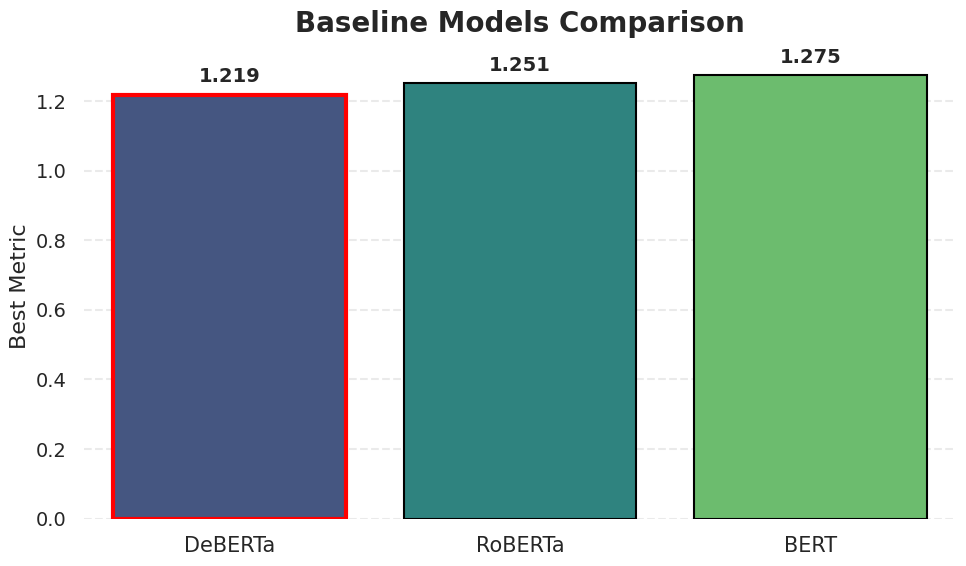

In [10]:
plt.figure(figsize=(10, 6))

ax = sns.barplot(
    data=df,
    x='model',
    y='best_metric',
    palette='viridis',
    edgecolor='black'
)

for container in ax.containers:
    ax.bar_label(
        container,
        fmt='%.3f',
        fontsize=14,
        padding=6,
        fontweight='bold'
    )

ax.set_title(
    'Baseline Models Comparison',
    fontsize=20,
    fontweight='bold',
    pad=15
)
ax.set_ylabel('Best Metric', fontsize=16)
ax.set_xlabel('', fontsize=14)

ax.tick_params(axis='x', labelsize=15)
ax.tick_params(axis='y', labelsize=14)

best_idx = df['best_metric'].idxmin()
ax.patches[best_idx].set_edgecolor('red')
ax.patches[best_idx].set_linewidth(3)

ax.grid(axis='y', linestyle='--', alpha=0.4)
sns.despine(left=True, bottom=True)

plt.tight_layout()
plt.savefig(OUT_DIR / 'fig1_baseline_barplot_large.png', dpi=300)
plt.show()
